In [1]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())
import sys
sys.executable
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/bin/python3')
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')

/home/misko/.local/share/jupyter


In [2]:
# Telling matplotlib to plot graphs inline
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import csv
#import cPickle as pickle
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import sys
import theano
import time
from matplotlib import cm

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

#import cPickle as pickle
import _pickle as pickle

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)
/home/misko/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

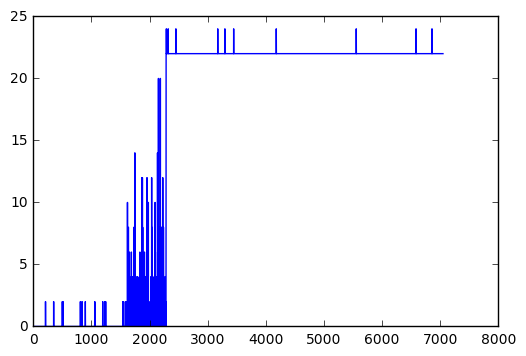

In [4]:
y_count_na = np.sum(np.isnan(y),1)
plt.plot(y_count_na)

In [5]:
# Just to get the functions to compile
train_data = X
train_labels = y

## STRETCH HISTOGRAMS

In [6]:

def stretch_histogram(frame):
    # Save the incoming 
    new_frame = []
    
    # Algorithm is very sensitive to outliers at both ends
    # So, focus on the 5th and 95th percentile points as as proposed by Song et al.
    a = np.percentile(frame, 5)
    b = np.percentile(frame, 95)
    u = 1 # desired_max_pixel_value
    l = 0 # desired_min_pixel_value

    # Algorithm fails to optimize if low and high values are at the extreme
    if a == 0 and b == 1:
        return(frame)
    
    # If frame is all white or all black, skip processing
    if a == 1 or b == 0:
        return(frame)

    for x in range(0, len(frame)):
        if (frame[x] > b):
            new_frame.append(np.float32(1.0))
        elif (frame[x] < a):
            new_frame.append(np.float32(0.0))
        else:
            p_prime = np.float32(((u - l) / (b - a)) * (frame[x] - a) - l)
            new_frame.append(p_prime)
            if (p_prime < 0) | (p_prime > 1):
                pass
                #print(x, p_prime)
    #print(np.array(new_frame))
    return np.array(new_frame).astype(np.float32)

# # Keep data consistent.
# np.random.seed(0)
# sample = np.random.rand(2) * len(train_data)

# for i in sample:
#     before = train_data[i]
#     after = stretch_histogram(train_data[i])

#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])


# # For python v2
# start = time.time()
# train_stretched = np.array(map(stretch_histogram, train_data))
# print("Finished stretching sample train_data map in %4f seconds" % (time.time() - start))


# For python v3
# Routine to stretch all histograms in training data
def stretch_histogram_all(train_data=train_data):
    train_hist_stretch = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_hist_stretch[index] = np.array(stretch_histogram(train_data[index]))
    return np.array(train_hist_stretch)

## SHIFT HISTOGRAMS

In [7]:
# Load data and shift
def shift_histogram_right(frame, shift=0.3):
    
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] + shift
        if new_value > 1.0:
            new_frame.append(np.float64(1.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of right shift
r_shift = 0.30


# for i in sample:
#     before = train_data[i]
#     after = shift_histogram_right(train_data[i], shift=r_shift)
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()

# train_shift_right = np.array(map(shift_histogram_right, train_data))
# print("Finished shifting RIGHT train_data in %4f seconds" % (time.time() - start))

# Load data and shift
def shift_histogram_left(frame, shift=0.3):
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] - shift
        if new_value < 0.0:
            new_frame.append(np.float64(0.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of left shift
l_shift = 0.2

# for i in sample:
#     before = train_data[i]
#     after = shift_histogram_left(train_data[i], shift=l_shift)
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()


# For python v3
# Routine(s) to shift all histograms in training data
def shift_histogram_right_all(train_data=train_data):
    train_shift_right = np.zeros((len(train_data), train_data.shape[1]))
    for index in range(0, len(train_data)):
        train_shift_right[index] = np.array(shift_histogram_right(train_data[index]))
    return np.array(train_shift_right)

def shift_histogram_left_all(train_data=train_data):
    train_shift_left = np.zeros((len(train_data), train_data.shape[1]))
    for index in range(0, len(train_data)):
        train_shift_left[index] = np.array(shift_histogram_left(train_data[index]))
    return np.array(train_shift_left)

## BLUR

In [8]:
def gaussian_blur(origin, matrix, blur=1):
    sd = 2
    pi = np.pi
    e = np.e
    cartesian = []
    coords = []
    weights = []
    blurred_pixel = 0.0

    x = origin[0]
    y = origin[1]
    
    for i in range(-blur, blur):
        for j in range(-blur, blur):
            cartesian.append([i, j])
            try:
                if ((x - i) == 0) | ((y - j) == 0):
                    raise IndexError
                coords.append(matrix[x + i][y + j])
            except IndexError:
                coords.append(matrix[x][y])
    weights = []
    for pair in cartesian:
        x = pair[0]
        y = pair[1]
        weight = (1.0 / (2 * pi * sd ** 2)) * (e ** -((x ** 2 + y ** 2) / (2 * sd ** 2))) # 2D Gaussian function
        weights.append(weight)
    averages = [w / sum(weights) for w in weights]
    for i in range(0, len(coords)):
        blurred_pixel += coords[i] * averages[i]

    return blurred_pixel

def apply_blur(img):
    blurred_matrix = []
    matrix = img.reshape(96, 96)
    for row in range(0, len(matrix)):
        for col in range(0, len(matrix[row])):
            origin = [row, col]
            blurred_matrix.append(gaussian_blur(origin, matrix))
    return np.array(blurred_matrix).astype(np.float32)


# np.random.seed(0)

# for i in sample:
#     before = train_data[i]
#     after = apply_blur(train_data[i])
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])


# For python v3
# Routine to gaussian shift all the images in the training data
def apply_blur_all(train_data=train_data):
    blur_all = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        blur_all[index] = np.array(apply_blur(train_data[index]))
    return np.array(blur_all)

## CRITICAL PIXEL ENHANCEMENT

In [9]:
# The labels and their indexes
critical_points = ["left_eye_center_x", "left_eye_center_y", 
                       "right_eye_center_x", "right_eye_center_y",
                       "left_eye_inner_corner_x", "left_eye_inner_corner_y", 
                       "left_eye_outer_corner_x", "left_eye_outer_corner_y",
                       "right_eye_inner_corner_x", "right_eye_inner_corner_y",
                        "right_eye_outer_corner_x", "right_eye_outer_corner_y",
                       "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y",
                       "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
                       "right_eyebrow_inner_end_x ", "right_eyebrow_inner_end_y", 
                       "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y",
                       "nose_tip_x", "nose_tip_y",
                        "mouth_left_corner_x", "mouth_left_corner_y",
                       "mouth_right_corner_x", "mouth_right_corner_y", 
                      "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y", 
                       "mouth_center_top_lip_x", "mouth_center_top_lip_y"
                  ]

import copy
import math
# This function sets up the 9 bins for digitizing the data for a frame X
def setup_heatmap(X):
    bins = np.arange(0, 1.0, 0.111) # Set up 9 bins for holding data
    
    # digitize the incoming data into bins
    binplace = np.digitize(X, bins, right=True)
    
    # Flatten for vector processing
    binplace = binplace.flatten()
    
    # return the bins
    return binplace


def computeCentroid(eye_1, eye_2):
    
    #print(eye_1, eye_2)
    center_eye_1 = [0,0]
    center_eye_2 = [0,0]
    
    if len(eye_1) > 0 and len(eye_2) > 0:
        # Put all the eye data together
        # print(len(eye_1), len(eye_2))
        eye_1_x,eye_1_y=list(zip(*eye_1))
        eye_2_x,eye_2_y=list(zip(*eye_2))
    
        # Compute the centroid coordinates. There most likley is a better formula
        center_eye_1=sum(eye_1_x)/len(eye_1), sum(eye_1_y)/len(eye_1)
        center_eye_2=sum(eye_2_x)/len(eye_2), sum(eye_2_y)/len(eye_2)
    
    return center_eye_1, center_eye_2

def PreProcessFrame(data, labels, plot=False):

    X = process_image(data, labels, plot=plot)

    labels = labels * 48 + 48
    # Attach a color with each bin, in this case 9 colors, one for each bin
    # We are not interested in all colors, only the colors that highlight the eyes. 
    # so, make other colors "white" so that they do not show.
    # Determined through trial and error that bins 2 and 3 are the best bins for the eyes
    cmap = colors.ListedColormap(['white', 'white', 'orange', 'red', 'white', 'white', 'white', 'white', 'white'])
    bounds=[0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    return binplace, X, X_flattened, labels

def determine_eye_coordinates(eye_indices):
    
    # Two lists are needed to hold the pixels that 
    # represent each eye
    eye_1_pos = []
    eye_2_pos = []

    processed_flag = 0
    # The eyes are usually part of the dark pixels in the images
    # And dark pixels are captured in the lowest 3 digitized bins. Learned through 
    # trial and error by observing the heat maps of multiple images

    # Now extract the two eye sets
    # The eyes fall within rectangles defined by multiple rows and columns
    # Each pixel is represented by a (row * column) number 
    # Start the count from the top left of the photo
    # The two rectangles are through the observation of multiple images
    for item in eye_indices:
        #print("Item is {}".format(item))
        if (item > 2900 and item < 2920) or \
            (item > 2996 and item < 3016) or \
            (item > 3092 and item < 3112) or \
            (item > 3188 and item < 3208) or \
            (item > 3284 and item < 3304) or \
            (item > 3380 and item < 3400) or \
            (item > 3476 and item < 3496) or \
            (item > 3572 and item < 3592) or \
            (item > 3668 and item < 3688) or \
            (item > 3764 and item < 3784) or \
            (item > 3860 and item < 3880):
            
            processed_flag = 1
            #print("Processed eye 1 {}".format(item))
            
            eye_1_pos_y = item//96  # The whole number part is the row or y
            eye_1_pos_x = item%96 # The fractional part is the column or x
        
            #print(eye_1_pos_x, eye_1_pos_y)
            # Add to a list that defines eye number 1
            eye_1_pos.append((eye_1_pos_x, eye_1_pos_y))
        
        # Do exactly the above for the second eye. Only the bounding rectangle is different
        elif (item > 2939 and item < 2959) or \
            (item > 3035 and item < 3055) or \
            (item > 3131 and item < 3151) or \
            (item > 3227 and item < 3247) or \
            (item > 3323 and item < 3343) or \
            (item > 3419 and item < 3439) or \
            (item > 3515 and item < 3535) or \
            (item > 3611 and item < 3631) or \
            (item > 3707 and item < 3727) or \
            (item > 3803 and item < 3823) or \
            (item > 3899 and item < 3919):
            
            processed_flag = 1
            #print("Processed eye 2 {}".format(item))
            
            eye_2_pos_y = item//96
            eye_2_pos_x = item%96
        
            #print(eye_2_pos_x, eye_2_pos_y)
            # List of pixels that define the second eye
            eye_2_pos.append((eye_2_pos_x, eye_2_pos_y))

    if processed_flag == 0:
        eye_1_pos = [(0,0)]
        eye_2_pos = [(0,0)]
        
    # Return the pixel coordinates of the 2 eye clusters
    return (eye_1_pos, eye_2_pos)


def VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False):
    # There is a possibility that the first chosen 2 bins do not have any eye pixel
    # Successively add a bin until there are non-zero data points in the eye rectangle
    # This is kludgy stuff - my apologies!
    processed_flag = 0
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Adding a bin")
        eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3))[0])
        eye_1, eye_2 = determine_eye_coordinates(eye_indices)
        if len(eye_1)==0 or len(eye_2)==0:
            if logging==True:
                print("Adding another bin")
            eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4))[0])
            eye_1, eye_2 = determine_eye_coordinates(eye_indices)
            if len(eye_1)==0 or len(eye_2)==0:
                if logging==True:
                    print("Adding yet another bin ")
                eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|(binplace==5))[0])
                eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                if len(eye_1)==0 or len(eye_2)==0:
                    if logging==True:
                        print("Adding the last 4 bins - the last attempt")
                    eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|\
                                        (binplace==5)|(binplace==6)|(binplace==7)|(binplace==8)|(binplace==9))[0])
                    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                    if len(eye_1)==0 or len(eye_2)==0:
                        eye_1=[]
                        eye_2=[]
                        if (logging==True):
                            print("Could not find eye pixels")
    return(eye_1, eye_2)

def reduce_and_darken_narrower_area(frame, eye_1, eye_2):

    if len(eye_1) > 6:
        del eye_1[int(2*len(eye_1)/3):] # delete the upper third
    

    if len(eye_1) > 6:
        eye_1 = eye_1[int(len(eye_1)/3):] # Remove the bottom third
    
    if len(eye_2) > 6:
        del eye_2[int(2* len(eye_2)/3):] # delete the upper third
        
    if len(eye_2) > 6:
        eye_2 = eye_2[int(len(eye_2)/3):] # Remove the bottom third

    # Eye1 1: For all remaining eye pixels, darken them by moving left
    for x in eye_1:
        #print("First eye coordinates {}". format(x))
        z = x[0] + x[1] * 96
        
        frame[z] -= 0.3 # Darken the pixel
        if frame[z] < 0:
            frame[z] = 0 # Don't go negative with darkening
    
    # Eye 2: For all remaining eye pixels, darken them by moving left
    for x in eye_2:
        #print("Second eye coordinates {}". format(x))
        z = x[0] + x[1] * 96
        
        frame[z] -= 0.2 # Darken the pixel
        if frame[z] < 0:
            frame[z] = 0 # Don't go negative with darkening
    return frame

def darken_eyes(frame, logging = False):

    #print("New Frame")
    X = np.reshape(frame,(96,96))

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    
    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])

    #print("darken_eyes: eye indices are {}".format(eye_indices))
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
    #print("darken_eyes: determined eye indices are {}".format(eye_1, eye_2))
    
    if len(eye_1)==0 or len(eye_2)==0:
        frame = shift_histogram_left(frame, shift=0.2)
        if logging==True:
            print("darken_eyes: Left shifted the image")
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False)
        
    eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False)
    
    # compute the centroid of both eyes
    #print(eye_1, eye_2)
    centroid_eye_1, centroid_eye_2 = computeCentroid(eye_1, eye_2)
    #print("Centroid is {} {}".format(centroid_eye_1, centroid_eye_2))
    # be selective about how many spots to darken. Stay close to the centroid
    # Visit at a later time
    
    if logging == True:
        plt.figure(figsize=(8, 4))
        plt.imshow(np.reshape(frame,(96,96)), cmap = cm.gray) 
    
    # Darken just the Centroids
    z1 = centroid_eye_1[0] + 96 * centroid_eye_1[1]
    z2 = centroid_eye_2[0] + 96 * centroid_eye_2[1]
    frame[z1] -= 0.15 # Darken the pixel
    frame[z2] -= 0.15 # Darken the pixel
    
    # Centoid has been darkened
    # Now work on the middle items in the list of eye pixels, ignore the outliers
    #frame = reduce_and_darken_narrower_area(frame, eye_1, eye_2)
    
    return frame

# Routine to loop through and darken all eyes in all images in training data
def darken_eyes_all(images, logging=False):
    for i in range(0, len(images)):
        #print("The image index is {}".format(i))
        images[i] = darken_eyes(images[i])
    return(np.array(images))

## ROTATION

In [10]:
# Given one frame and coordinates of its labels...
# 
# If "plot" is True, show the red dots on the image and return a 96 by 96 matrix
# If "plot" is False, just return a 96 by 96 matrix
def process_image(image, labels, plot=False): 

    if plot == True:
        labels = labels * 48 + 48
        #plt.figure(figsize=(8, 4))
        #print("process_image I")
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray) 
        for x, y in np.reshape(labels,(len(labels)/2, 2)):
            plt.plot(x, y, 'r.')
        plt.axis('off')
        plt.show()
    return np.reshape(image,(96,96))


from math import *

def getAngleBetweenPoints(x_1, y_1, x_2, y_2):
    deltaY = y_2 - y_1
    deltaX = x_2 - x_1
    angle = atan2(deltaY, deltaX) # angle in radians
    
    # convert angle to degrees and return
    return angle * 180/pi


def rotate_point(centerPoint,point,angle):
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , \
                              temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

def rotate_labels(labels, label_count, axis, angle):
    labels_rotated=[]

    for i in range(0, label_count, 2):
        point=[labels[i], labels[i+1]]
        new_x, new_y = rotate_point(axis, point, angle)
        labels_rotated.append((new_x, new_y))
    return labels_rotated

from matplotlib import colors
from skimage import data
from skimage.transform import rotate

# Rotate the image
# "data" here is one image frame
def image_rotate(data=train_data, labels=train_labels, plot=False, \
                                                 logging = False, label_count=30):

    # ensure that the rotation direction is logged
    rotation_direction=1  # anti-clockwise by default
    angle = 0
    
    
    # Preprocess the data 
    binplace, X, X_flattened, labels = PreProcessFrame(data, labels, plot=plot)

    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])
    
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)

    loopIndex = 0
    shift = 0.2
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_left(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via darkening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error I - Image is too light")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    loopIndex = 0
    shift = 0.3
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_right(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via lightening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error II - too dark")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    # One last net to catch data where eye cannot be recognized
    # If there is a picture where no pixels appear in the eye rectangle,
    # we have no choice but to give up. I have not seen this happen. 
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Eye index is zero, sending back original data")
        return labels, X_flattened
    
    # I was not sure how an assignment of X into X_flattened would work, so I decided 
    # to make an explicit copy. I needed a copy because we are going to munge this
    # new frame with rotated pixel values. Start by initializing all pixels to 0
    #Xcopy = X_flattened.copy()
    Xcopy=X_flattened
#     for i in X_flattened:
#         Xcopy[i] = 0
        
    # The visual of having located the eye pixels and overlaying them on the 
    # original image is powerful
    # Plot the eye pixels on top of the original image
    if plot==True and logging==True:
        plt.scatter(*zip(*eye_1))
        plt.scatter(*zip(*eye_2))
    
    if len(eye_indices) != 0:
        for element in eye_indices:
            Xcopy[element] = X_flattened[element]
    else:
        if logging==True:
            print("eye_indices is zero")

    # Reshape for further processing
    Xcopy = np.reshape(Xcopy,(96,96))

    center_eye_1, center_eye_2 = computeCentroid(eye_1, eye_2)

    if logging==True:
        print("The centroid values are {} {}".format(center_eye_1, center_eye_2))

    # compute  the angle with the horizontal
    # using the coordinates of the 2 eyes
    angle = getAngleBetweenPoints(center_eye_1[0], center_eye_1[1], \
                                      center_eye_2[0], center_eye_2[1])

    # Needs skimage imports
    if (center_eye_2[1] < center_eye_1[1]):
        #print("Anti clockwise rotation") because left eye is lower than the right eye, 
        # right eye is axis
        X_rotated = rotate(X, 360 - abs(angle), center = [center_eye_2[0], center_eye_2[1]], \
                                   mode = 'symmetric',\
                                   resize = False, clip = True, preserve_range = True)
        #Rotate the labels
        if logging==True:
            print("C angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, label_count, [center_eye_2[0], \
                                                        center_eye_2[1]], -angle)
        angle = 360-angle
        rotation_direction=1

    else:
        #print("Anti clockwise rotation"), right eye is lower than the left eye, left eye is axis
        X_rotated = rotate(X, abs(angle), center =[center_eye_1[0], center_eye_1[1]], \
                                   mode='symmetric',\
                                  resize = False, clip = True, preserve_range = True)
    
        #Rotate the labels
        if logging==True:
            print("AC angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, label_count, [center_eye_1[0], \
                                                             center_eye_1[1]], -angle)
        angle = -angle
        rotation_direction=0
        
    # Not sure why I check but I want  to make sure that we have an array of size 9216
    if X_rotated.flatten().shape[0] != 9216:
        if logging==True:
            print("Something wrong {}".format(X_rotated.flatten().shape[0]))

    # Return the rotated image and its parameters
    return rotated_labels, X_rotated



        
def sample_rotate(train_data=train_data, train_labels=train_labels, sample=100, \
                                              logging=False, label_count=30):
    # ROTATION 
    # The main calls are here
    plot=False
    # Rotate the images
    rotated_labels, rotated_image = image_rotate(data = train_data[sample], \
                        labels = train_labels[sample], plot=plot, logging=logging, \
                                                 label_count=label_count)

    if logging==True:
        # show the original
        plt.imshow(np.reshape(train_data[sample],(96,96)), cmap = cm.gray)
        plt.show()

        # Now show the rotated image
        if rotated_image is not None:
            labels = np.array((np.array(rotated_labels) -48)/48)
            labels = labels.flatten()
            process_image(image = np.array(rotated_image), \
                          labels = labels, plot=True)

    return np.array(rotated_image).flatten(), np.array(rotated_labels).flatten()
            
def sample_rotate_all(train_data=train_data, train_labels=train_labels, label_count=30):

    samples = len(train_data)
    logging = False
    plot = True
    # allocate storage for results
    print("sample_rotate all")
    train_rotated = np.zeros((len(train_data), train_data.shape[1]))
    labels_rotated = np.zeros((len(train_data), train_labels.shape[1]))
    
    # For the training samples
    for sample in range(0, samples):
            train_rotated[sample], labels_rotated[sample] = \
                        sample_rotate(train_data=train_data, train_labels=train_labels,\
                                        sample=sample, logging=False, label_count=label_count)
    print(train_rotated.shape, labels_rotated.shape)
    return train_rotated, labels_rotated
        

## REFLECTION

In [11]:
def reflect_all_by_y_axis (train_data=train_data, train_labels=train_labels,\
                                       labels=False,label_count=30,logging=False):
#     print(train_data.shape)
#     print(type(train_data))
#     print(train_labels.shape)
#     print(type(train_labels))
    train_data_y_reflection = np.zeros((len(train_data), train_data.shape[1]))
    
    if labels==True:
        #train_labels_y_reflection = train_labels.copy()
        train_labels_y_reflection = train_labels
        train_labels_y_reflection = train_labels_y_reflection*48 + 48
    
    for i in range(0,len(train_data)):
        # For debugging only. 
        if logging==True and i==300 and labels==True:
            
            plt.figure(figsize=(8, 4))
            plt.imshow(np.reshape(train_data[i],(96,96)), cmap = cm.gray)
            
            #print(train_labels[200])
            for x, y in np.reshape(train_labels_y_reflection[i], \
                                       (len(train_labels_y_reflection[i])/2, 2)):
                plt.plot(x, y, 'r.')
                plt.title("Reflection around the Y axis: Original frame")
                plt.ylim([96,0])
                plt.xlim([0,96])

        # Make a copy because we will be manipualting the data
        #train_data_temp = list(train_data[i].copy())
        train_data_temp = list(train_data[i])
        
        # we need to loop 96 times (0 to 95), one for each line of pixels
        N=0
        while N <= 96*95:
            
            # Read the line of pixels and reverse it
            train_data_temp[N:N+96] = train_data_temp[N:N+96][::-1]
            
            # go to the next line
            N += 96
        
        # Picture has been reflected. Save it and work on labels next
        train_data_y_reflection[i] = train_data_temp
        
        # Now, reflect the labels, if labels = True
        # To convert the labels, there are 30 labels, do reflection in pairs, hence step by 2
        # y coordinate does not change, only the x coordinate changes.
        # Loop through and stop at 29 because we only have 30 labels
        if labels==True:
            # use a temporary variable to hold the labels data
            labels_tmp = list(train_labels_y_reflection[i])
            
            if label_count==30:
                #flip_indices = [(0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11),(12, 16), (13, 17),\
                #               (14, 18), (15, 19),(22, 24), (23, 25),]
                labels_tmp[0], labels_tmp[2] = 96-labels_tmp[2], 96-labels_tmp[0]
                labels_tmp[1], labels_tmp[3] = labels_tmp[3], labels_tmp[1]
                labels_tmp[4], labels_tmp[8] = 96-labels_tmp[8], 96-labels_tmp[4]
                labels_tmp[5], labels_tmp[9] = labels_tmp[9], labels_tmp[5]
                labels_tmp[6], labels_tmp[10] = 96-labels_tmp[10], 96-labels_tmp[6]
                labels_tmp[7], labels_tmp[11] = labels_tmp[11], labels_tmp[7]
                labels_tmp[12], labels_tmp[16] = 96-labels_tmp[16], 96-labels_tmp[12]
                labels_tmp[13], labels_tmp[17] = labels_tmp[17], labels_tmp[13]
                labels_tmp[14], labels_tmp[18] = 96-labels_tmp[18], 96-labels_tmp[14]
                labels_tmp[15], labels_tmp[19] = labels_tmp[19], labels_tmp[15]
                labels_tmp[22], labels_tmp[24] = 96-labels_tmp[24], 96-labels_tmp[22]
                labels_tmp[23], labels_tmp[25] = labels_tmp[25], labels_tmp[23]

                # Nose tip 
                labels_tmp[20], labels_tmp[21] = 96-labels_tmp[20], labels_tmp[21]

                # Mouth bottom
                labels_tmp[26], labels_tmp[27] = 96-labels_tmp[26], labels_tmp[27]

                # Mouth top
                labels_tmp[28], labels_tmp[29] = 96-labels_tmp[28], labels_tmp[29]
            elif label_count==8:
                labels_tmp[0], labels_tmp[2] = 96-labels_tmp[2], 96-labels_tmp[0]
                labels_tmp[1], labels_tmp[3] = labels_tmp[3], labels_tmp[1]
                labels_tmp[4], labels_tmp[5] = 96-labels_tmp[4], labels_tmp[5]
                labels_tmp[6], labels_tmp[7] = 96-labels_tmp[6], labels_tmp[7]
            
            # for every picture/frame, save all the y coordinate changes
            train_labels_y_reflection[i] = np.array(labels_tmp)


        # For debugging only. 
        if labels==True and logging==True and i==300:
            plt.figure(figsize=(8, 4))
            plt.imshow(np.reshape(train_data_y_reflection[i],(96,96)), cmap = cm.gray)
            
            for x, y in np.reshape(train_labels_y_reflection[i], (len(train_labels_y_reflection[i])/2, 2)):
                plt.plot(x, y, 'b.')
                plt.title("Reflection around  the Y axis: Reflected frame")
                plt.ylim([96,0])
                plt.xlim([0,96])

    # return the reflected frames
    return train_data_y_reflection, train_labels_y_reflection

In [12]:
idx_ds_2 = y_count_na.tolist().index(22)


img_ds_30 = X[:idx_ds_2]
img_ds_8 = X[idx_ds_2:]

train_ds_30 = y[:idx_ds_2]
train_ds_8 = y[idx_ds_2:]

print(img_ds_30.shape, img_ds_8.shape)
print(train_ds_30.shape, train_ds_8.shape)

(2284, 9216) (4765, 9216)
(2284, 30) (4765, 30)


In [13]:
keypoints = ['left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y','left_eye_inner_corner_x', \
             'left_eye_inner_corner_y','left_eye_outer_corner_x','left_eye_outer_corner_y','right_eye_inner_corner_x', \
             'right_eye_inner_corner_y','right_eye_outer_corner_x','right_eye_outer_corner_y','left_eyebrow_inner_end_x', \
             'left_eyebrow_inner_end_y','left_eyebrow_outer_end_x','left_eyebrow_outer_end_y','right_eyebrow_inner_end_x', \
             'right_eyebrow_inner_end_y','right_eyebrow_outer_end_x','right_eyebrow_outer_end_y','nose_tip_x','nose_tip_y', \
             'mouth_left_corner_x','mouth_left_corner_y','mouth_right_corner_x','mouth_right_corner_y', \
             'mouth_center_top_lip_x','mouth_center_top_lip_y','mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']

keypoints_ds_8 = [0,1,2,3,20,21,28,29]


train_ds_8_sub = train_ds_8[:,keypoints_ds_8]
print(train_ds_8_sub.shape)

(4765, 8)


In [14]:
train_8_nona_idx = np.sum(np.isnan(train_ds_8_sub),1) == 0
train_30_nona_idx = np.sum(np.isnan(train_ds_30),1) == 0

img_8_nona = img_ds_8[train_8_nona_idx]
img_30_nona = img_ds_30[train_30_nona_idx]

train_8_nona = train_ds_8_sub[train_8_nona_idx]
train_30_nona = train_ds_30[train_30_nona_idx]

print(img_8_nona.shape, img_30_nona.shape)
print(train_8_nona.shape, train_30_nona.shape)

(4755, 9216) (2140, 9216)
(4755, 8) (2140, 30)


In [15]:
sys.setrecursionlimit(10000)

def float32(var):
    return np.cast['float32'](var)


#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs + 1)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-4, 1e-2)
    plt.yscale("log")
    plt.show()

In [16]:
from nolearn.lasagne import BatchIterator

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

In [17]:
def get_model():
    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),  # !
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('dropout2', layers.DropoutLayer),  # !
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('dropout3', layers.DropoutLayer),  # !
            ('conv4', layers.Conv2DLayer),
            ('pool4', layers.MaxPool2DLayer),
            ('dropout4', layers.DropoutLayer),  # !
            ('hidden5', layers.DenseLayer),
            ('hidden6', layers.DenseLayer),
            ('hidden7', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, 96, 96),
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
        dropout1_p=0.1,  # !
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        dropout2_p=0.2,  # !
        conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
        dropout3_p=0.3,  # !
        conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
        dropout4_p=0.4,  # !
        hidden5_num_units=500,
        hidden6_num_units=500,
        hidden7_num_units=500,
        output_num_units=8, output_nonlinearity=None,

        update_learning_rate=theano.shared(float32(0.03)),
        update_momentum=theano.shared(float32(0.9)),

        regression=True,
        batch_iterator_train=FlipBatchIterator(batch_size=128),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
            AdjustVariable('update_momentum', start=0.9, stop=0.999),
            EarlyStopping(patience=200),
            ],
        max_epochs=1000,
        verbose=1,
        )
    return net

In [18]:
SPECIALIST_SETTINGS_8 = [
    dict(
        columns=(0, 1, 2, 3),
#             (
#             'left_eye_center_x', 'left_eye_center_y',
#             'right_eye_center_x', 'right_eye_center_y',
#             ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(4,5),
#             (
#             'nose_tip_x', 'nose_tip_y',
#             ),
        flip_indices=(),
        ),

    dict(
        columns=(6,7),
#             (
#             'mouth_center_bottom_lip_x',
#             'mouth_center_bottom_lip_y',
#             ),
        flip_indices=(),
        )
    ]

In [19]:
SPECIALIST_SETTINGS_30 = [
    dict(
        columns=(0,1,2,3),
#             (
#             'left_eye_center_x', 'left_eye_center_y',
#             'right_eye_center_x', 'right_eye_center_y',
#             ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(20,21),
#             (
#             'nose_tip_x', 'nose_tip_y',
#             ),
        flip_indices=(),
        ),

    dict(
        columns=(22,23,24,25,26,27),
#             (
#             'mouth_left_corner_x', 'mouth_left_corner_y',
#             'mouth_right_corner_x', 'mouth_right_corner_y',
#             'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
#             ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(28,29),
#             (
#             'mouth_center_bottom_lip_x',
#             'mouth_center_bottom_lip_y',
#             ),
        flip_indices=(),
        ),

    dict(
        columns=(4,5,6,7,8,9,10,11),
#             (
#             'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
#             'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
#             'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
#             'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
#           ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(12,13,14,15,16,17,18,19),
#             (
#             'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
#             'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
#             'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
#             'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
#             ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

## Manipulate images with label_count attributes

In [20]:
def process_data(train_data=img_30_nona, train_labels=train_30_nona, label_count=30):
    print("Reflect frames around y axis - START")
    reflected_data, reflected_labels = \
            reflect_all_by_y_axis(train_data, train_labels, \
                                  labels=True, label_count=label_count, logging=True)

    print(reflected_data.shape)
    print(reflected_labels.shape)

    # First get the y axis reflection and append it to train_data
    reflected_labels=(reflected_labels - 48)/48
    augmented_data=np.concatenate((train_data, reflected_data), axis=0)
    augmented_labels=np.concatenate((train_labels, reflected_labels), axis=0)

    print(augmented_data.shape)
    print(augmented_labels.shape)

    # Now rotate the data to generate the 3rd block of train data
    rotated_data_tmp, rotated_labels_tmp = \
                    sample_rotate_all(train_data=augmented_data, train_labels=augmented_labels, label_count=label_count)

    augmented_data_final = np.vstack((augmented_data, rotated_data_tmp))
    rotated_labels_tmp = (rotated_labels_tmp - 48)/48
    augmented_labels_final = np.vstack((augmented_labels, rotated_labels_tmp))

    print(augmented_data_final.shape)
    print(augmented_labels_final.shape)

    #print(train_data)
    from datetime import datetime
    print(str(datetime.now()))
    print("Starting the generation of composite data")
    transformed_data_1 = stretch_histogram_all(augmented_data_final)
    #transformed_data = stretch_histogram_all(train_data)
    # print(transformed_data.shape)
    # print(transformed_data)
    print("Finished stretching. Starting left shift")
    print(str(datetime.now()))
    transformed_data_2 = shift_histogram_left_all(transformed_data_1)
    # print(transformed_data.shape)
    # print(transformed_data)
    print("Finished shifting")

    print("Starting Blur")
    print(str(datetime.now()))
    transformed_data_3 = apply_blur_all(transformed_data_2)
    # print(transformed_data.shape)
    # print(transformed_data)
    print("Finished Blur")
    print(str(datetime.now()))

    print(str(datetime.now()))
    print("Start darkening eyes")
    transformed_data = darken_eyes_all(images=transformed_data_3)
    # print(transformed_data.shape)
    # print(transformed_data)
    print("Finished darkening eyes")
    print(transformed_data.shape)
    print(augmented_labels_final.shape)
    
    return np.array(transformed_data), np.array(augmented_labels_final)

In [21]:
# def load2d(cols, dtype = 8):
#     if dtype == 8:
#         return img_8_nona.reshape(-1, 1, 96, 96), train_8_nona[:,cols]
#     elif dtype == 30:
#         return img_30_nona.reshape(-1, 1, 96, 96), train_30_nona[:,cols]

In [ ]:
from collections import OrderedDict
from sklearn.base import clone

def fit_specialists(train_data, train_labels, dtype = 8):
    
    X = train_data
    y = train_labels
    specialists = OrderedDict()
    spec = None
    if dtype == 8:
        spec = SPECIALIST_SETTINGS_8
    else:
        spec = SPECIALIST_SETTINGS_30
        
    loopcount = 0
    for setting in spec:
        cols = setting['columns']
       
        if loopcount==0 and dtype==8:
            X, y = process_data(X, y, label_count=8)
            img_8_nona = X
            train_8_nona = y
            loopcount += 1
        elif loopcount==0 and dtype==30:
            X, y = process_data(X, y, label_count=30)
            img_30_nona = X
            train_30_nona = y
            loopcount += 1
        
        if dtype == 8:
            X, y = img_8_nona.reshape(-1, 1, 96, 96), train_8_nona[:,cols]
        elif dtype == 30:
            X, y = img_30_nona.reshape(-1, 1, 96, 96), train_30_nona[:,cols]
        
        model = get_model()
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        # set number of epochs relative to number of training examples:
        model.max_epochs = 250
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X.astype(np.float32), y.astype(np.float32))
        specialists[cols] = model
        graph_results(model)
    return specialists

Reflect frames around y axis - START
(4755, 9216)
(4755, 8)
(9510, 9216)
(9510, 8)
sample_rotate all
(9510, 9216) (9510, 8)
(19020, 9216)
(19020, 8)
2017-01-05 22:11:07.102466
Starting the generation of composite data
Finished stretching. Starting left shift
2017-01-05 22:34:43.508670
Finished shifting
Starting Blur
2017-01-05 22:36:19.671534
Finished Blur
2017-01-05 23:37:42.840408
2017-01-05 23:37:42.848905
Start darkening eyes
Finished darkening eyes
(19020, 9216)
(19020, 8)
Training model for columns (0, 1, 2, 3) for 500 epochs
# Neural Network with 13476304 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  h

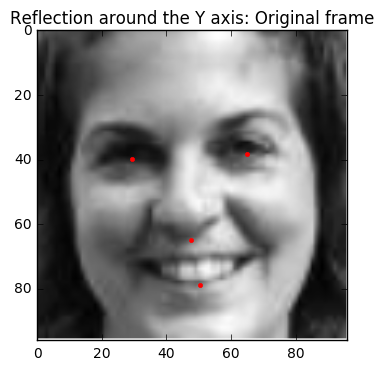

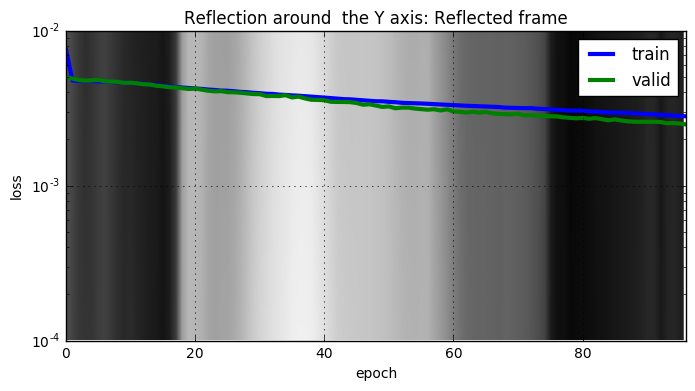

Training model for columns (4, 5) for 500 epochs
# Neural Network with 13475302 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.00942     0.00777    1.21148  35.63s
      2     0.00771     0.00768    1.00361  35.58s
      3     0.00761     0.00756    1.00716  35.58s
      4     0.00747     0.00749    0.99706  35.57s
      5     0.00730     0.00718    1.01612  35.58s
      6     0.00709     0.00704    1.00732  35.57s
      7     0.00689     0.00675   

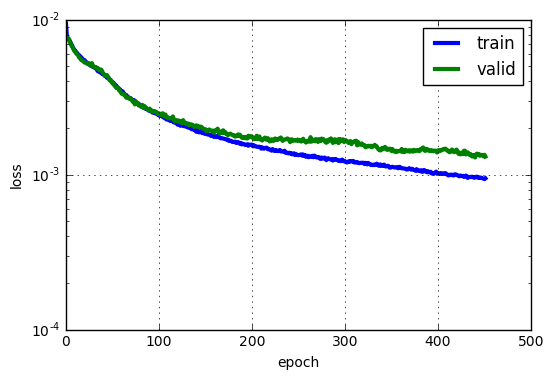

Training model for columns (6, 7) for 500 epochs
# Neural Network with 13475302 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.01285     0.00943    1.36313  36.45s
      2     0.00933     0.00938    0.99504  36.10s
      3     0.00925     0.00935    0.98956  35.79s
      4     0.00910     0.00904    1.00674  36.15s
      5     0.00892     0.00883    1.01014  36.36s
      6     0.00868     0.00852    1.01867  36.55s
      7     0.00845     0.00809   

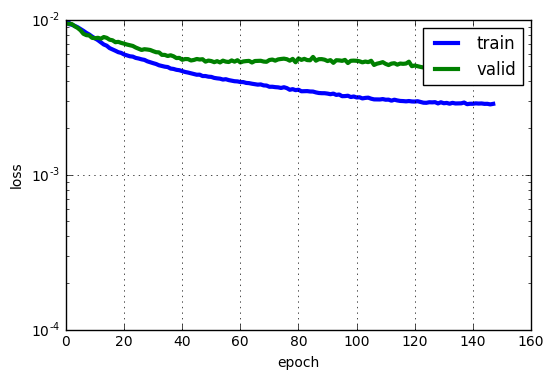

In [27]:
spec_8 = fit_specialists(img_8_nona, train_8_nona, 8)
with open('net-specialists_8.pickle', 'wb') as f:
    # we persist a dictionary with all models:
    pickle.dump(spec_8, f, -1)

Reflect frames around y axis - START
(2140, 9216)
(2140, 30)
(4280, 9216)
(4280, 30)
sample_rotate all
(4280, 9216) (4280, 30)
(8560, 9216)
(8560, 30)
2017-01-06 10:42:07.595835
Starting the generation of composite data
Finished stretching. Starting left shift
2017-01-06 10:52:43.018618
Finished shifting
Starting Blur
2017-01-06 10:53:20.882131
Finished Blur
2017-01-06 11:20:45.921917
2017-01-06 11:20:45.921993
Start darkening eyes
Finished darkening eyes
(8560, 9216)
(8560, 30)
Training model for columns (0, 1, 2, 3) for 500 epochs
# Neural Network with 13476304 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  

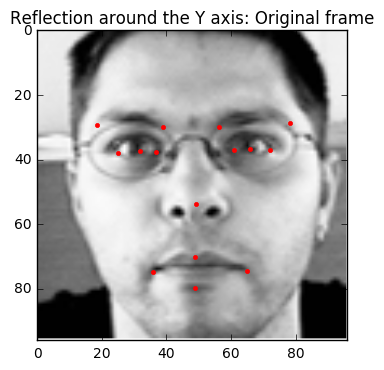

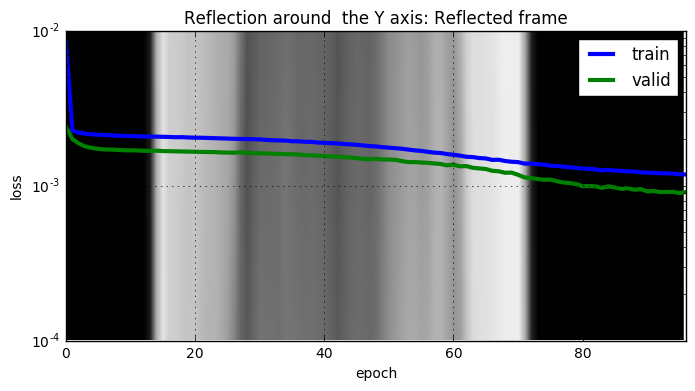

Training model for columns (20, 21) for 500 epochs
# Neural Network with 13475302 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.00956     0.00573    1.66902  16.48s
      2     0.00773     0.00571    1.35349  16.55s
      3     0.00755     0.00558    1.35181  16.13s
      4     0.00734     0.00539    1.36211  16.13s
      5     0.00710     0.00517    1.37225  16.14s
      6     0.00680     0.00495    1.37420  16.13s
      7     0.00661     0.00478 

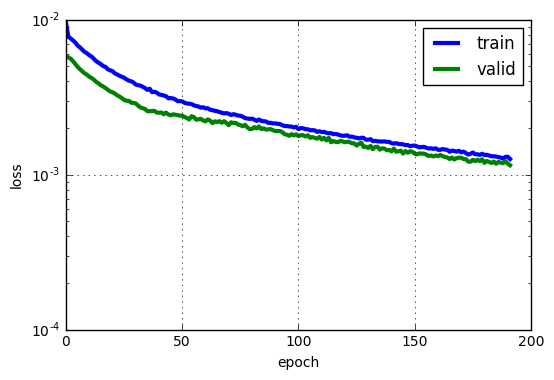

Training model for columns (22, 23, 24, 25, 26, 27) for 500 epochs
# Neural Network with 13477306 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    6

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.02355     0.00594    3.96220  16.44s
      2     0.00792     0.00578    1.37098  16.15s
      3     0.00764     0.00569    1.34311  16.15s
      4     0.00747     0.00562    1.33054  16.15s
      5     0.00732     0.00555    1.31905  16.16s
      6     0.00718     0.00545    1.31592  16.15s
      7     0.00

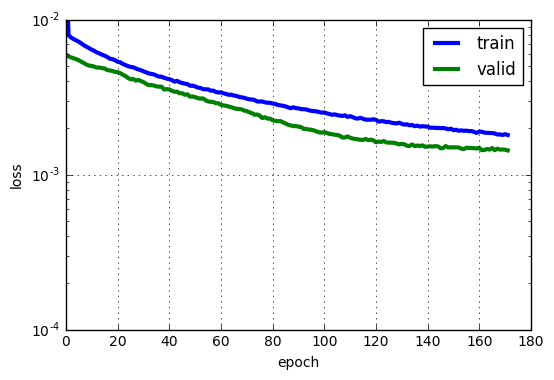

Training model for columns (28, 29) for 500 epochs
# Neural Network with 13475302 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.01619     0.01183    1.36807  16.59s
      2     0.00807     0.00857    0.94241  16.61s
      3     0.00777     0.00793    0.98051  16.60s
      4     0.00762     0.00753    1.01096  16.17s
      5     0.00749     0.00726    1.03118  16.12s
      6     0.00737     0.00711    1.03575  16.12s
      7     0.00727     0.00700 

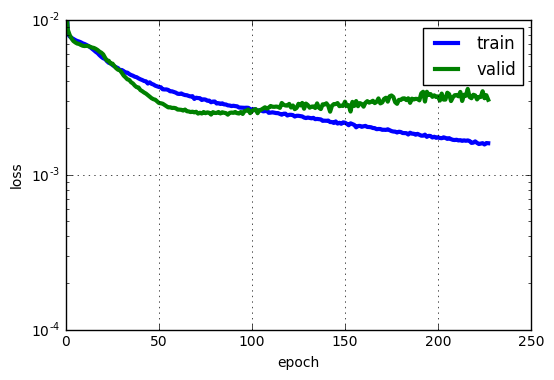

Training model for columns (4, 5, 6, 7, 8, 9, 10, 11) for 500 epochs
# Neural Network with 13478308 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.07928     0.07673    1.03315  16.49s
      2     0.07651     0.07712    0.99221  16.13s
      3     0.07621     0.07091    1.07468  16.13s
      4     0.07612     0.07300    1.04279  16.12s
      5     0.07618     0.07677    0.99225  16.13s
      6     0.07594     0.07614    0.99743  16.14s
      7     0.

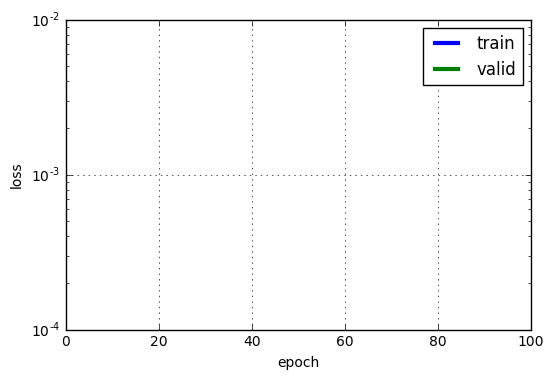

Training model for columns (12, 13, 14, 15, 16, 17, 18, 19) for 500 epochs
# Neural Network with 13478308 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.10194     0.09551    1.06729  16.64s
      2     0.09316     0.09214    1.01110  16.75s
      3     0.09308     0.09281    1.00284  16.87s
      4     0.09287     0.09423    0.98552  16.53s
      5     0.09274     0.09199    1.00805  16.79s
      6     0.09268     0.08378    1.10626  16.74s
      7 

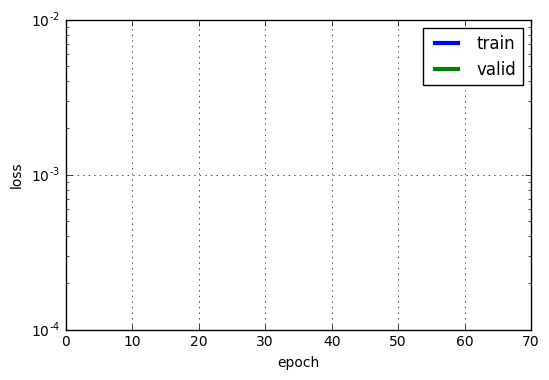

In [28]:
spec_30 = fit_specialists(img_30_nona, train_30_nona,30)
with open('net-specialists_30.pickle', 'wb') as f:
    # we persist a dictionary with all models:
    pickle.dump(spec_30, f, -1)

591


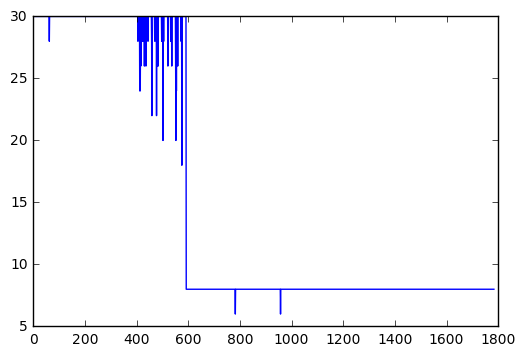

In [30]:
FLOOKUP = '../data/IdLookupTable.csv'
submissionImages = read_csv(os.path.expanduser(FLOOKUP))
subKeypoints = submissionImages.groupby(['ImageId']).size()
idx_sub_ds_8 = subKeypoints.tolist().index(8)
print (idx_sub_ds_8)
plt.plot(subKeypoints)

In [31]:
# Prep test data
test_img, foo = load(test=True) 
test_img_30 = test_img[:idx_sub_ds_8]
test_img_8 = test_img[idx_sub_ds_8:]

print (test_img_30.shape, test_img_8.shape)

test_img_30_2d = test_img_30.reshape(len(test_img_30), 1, 96, 96)
test_img_8_2d = test_img_8.reshape(len(test_img_8), 1, 96, 96)

print (test_img_30_2d.shape, test_img_8_2d.shape)

ImageId    1783
Image      1783
dtype: int64
(591, 9216) (1192, 9216)
(591, 1, 96, 96) (1192, 1, 96, 96)


In [32]:
res_8 = None
for colIdx, m in spec_8.items():
    y_hat = m.predict(test_img_8_2d)
    if res_8 == None:
        res_8 = y_hat
    else:
        res_8 = np.concatenate((res_8, y_hat), axis=1)
print (res_8.shape)
print (res_8[:5,])

(1192, 8)
[[ 0.32556981 -0.22280747 -0.32642746 -0.20185253  0.02315425  0.2810117
   0.03886794  0.64188033]
 [ 0.36096296 -0.2476076  -0.36184007 -0.23200685  0.00873773  0.36401433
  -0.00853558  0.65284175]
 [ 0.4624154  -0.16787252 -0.30307788 -0.27367944  0.02553513  0.44403353
  -0.02287626  0.70326489]
 [ 0.41838399 -0.27995595 -0.36282295 -0.26225302 -0.03268052  0.35707852
   0.00913171  0.64429379]
 [ 0.36980444 -0.23582636 -0.32595864 -0.1851631   0.0151256   0.3625198
   0.01888186  0.5867337 ]]


In [36]:
print(type(spec_30))
print(spec_30.items()[0])

<class 'collections.OrderedDict'>


TypeError: 'odict_items' object does not support indexing

In [37]:
res_30 = None
model_order = [0,4,5,1,2,3]
for mo in model_order:
    colIdx, m = list(spec_30.items())[mo]
    y_hat = m.predict(test_img_30_2d)
    if res_30 == None:
        res_30 = y_hat
    else:
        res_30 = np.concatenate((res_30, y_hat), axis=1)
print (res_30.shape)
print (res_30[:5,])

(591, 30)
[[ 0.37993115 -0.24807    -0.38209286 -0.25670975  0.25671357 -0.22140145
   0.52567017 -0.20709831 -0.2588754  -0.22612821 -0.53286529 -0.21575236
  -0.01492506 -0.3654072   0.46035194 -0.37184182  0.00306138 -0.3806349
  -0.48362583 -0.35356423  0.00952273  0.08569971  0.29605865  0.54280102
  -0.30747366  0.54441166  0.00099313  0.45753059 -0.01997148  0.5578109 ]
 [ 0.37560087 -0.27119261 -0.38965589 -0.26316178 -0.31563589 -0.25255013
  -0.01251967 -0.25614029  0.31299642 -0.25274998  0.02916878 -0.24741139
  -0.31964174 -0.40129369  0.13846557 -0.42013478  0.29521027 -0.41564059
  -0.16330281 -0.40229666  0.01391061  0.19523731  0.32042086  0.6227777
  -0.28224516  0.64440352  0.02288328  0.62560874 -0.01039366  0.6156289 ]
 [ 0.35414517 -0.24828701 -0.36284664 -0.22569361  0.21977893 -0.23513103
   0.48248839 -0.22278671 -0.22541997 -0.23661698 -0.49439377 -0.23562326
   0.13244978 -0.37800455  0.57758844 -0.3761819  -0.13737498 -0.39144453
  -0.57312524 -0.36174461  0

In [38]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

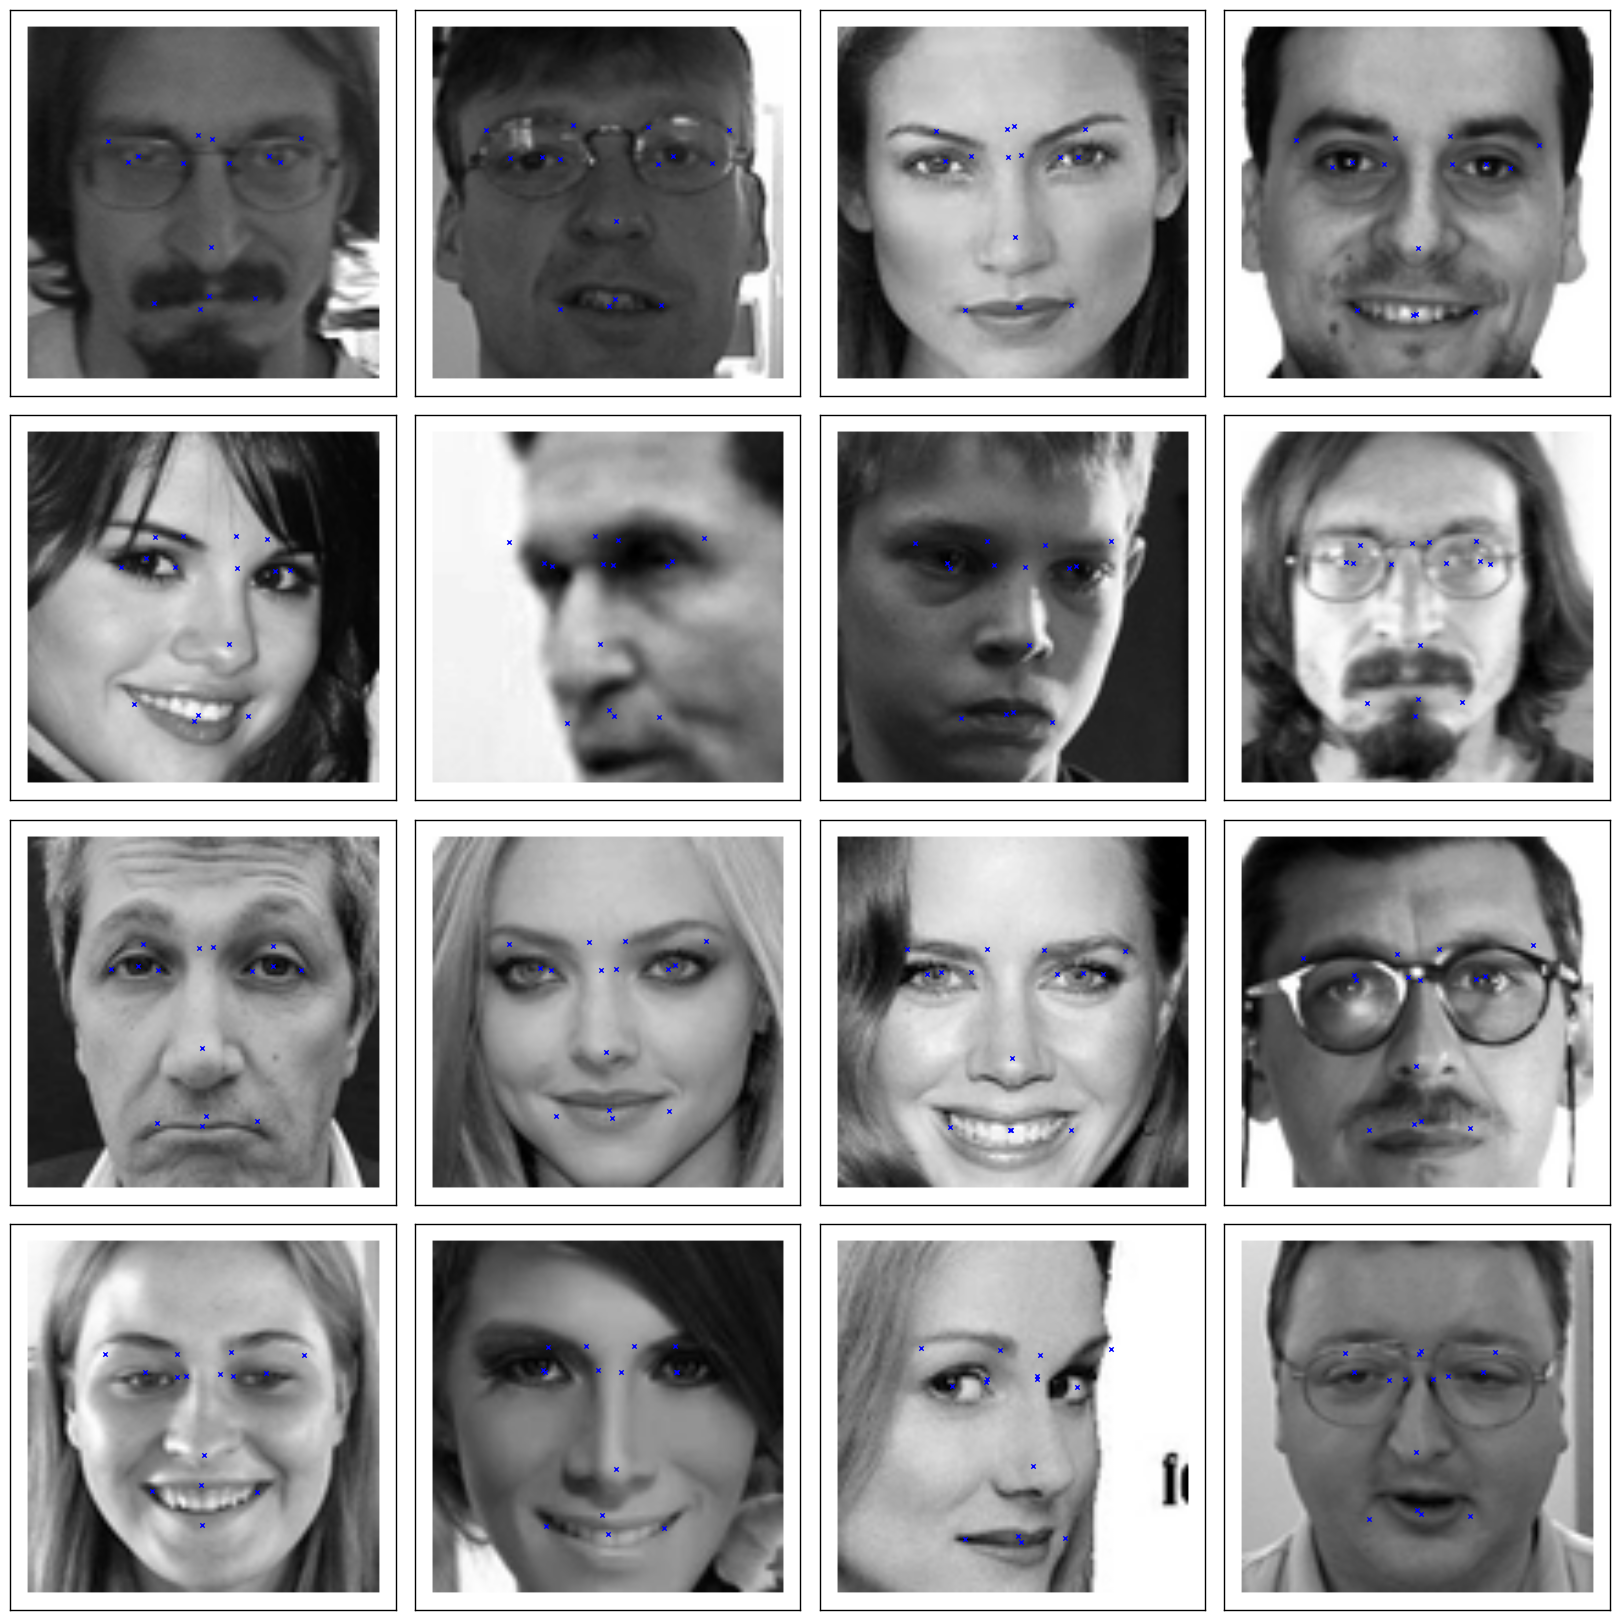

In [39]:
from random import randint

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(res_30))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_30[test_idx], res_30[test_idx], ax)
    
plt.show()

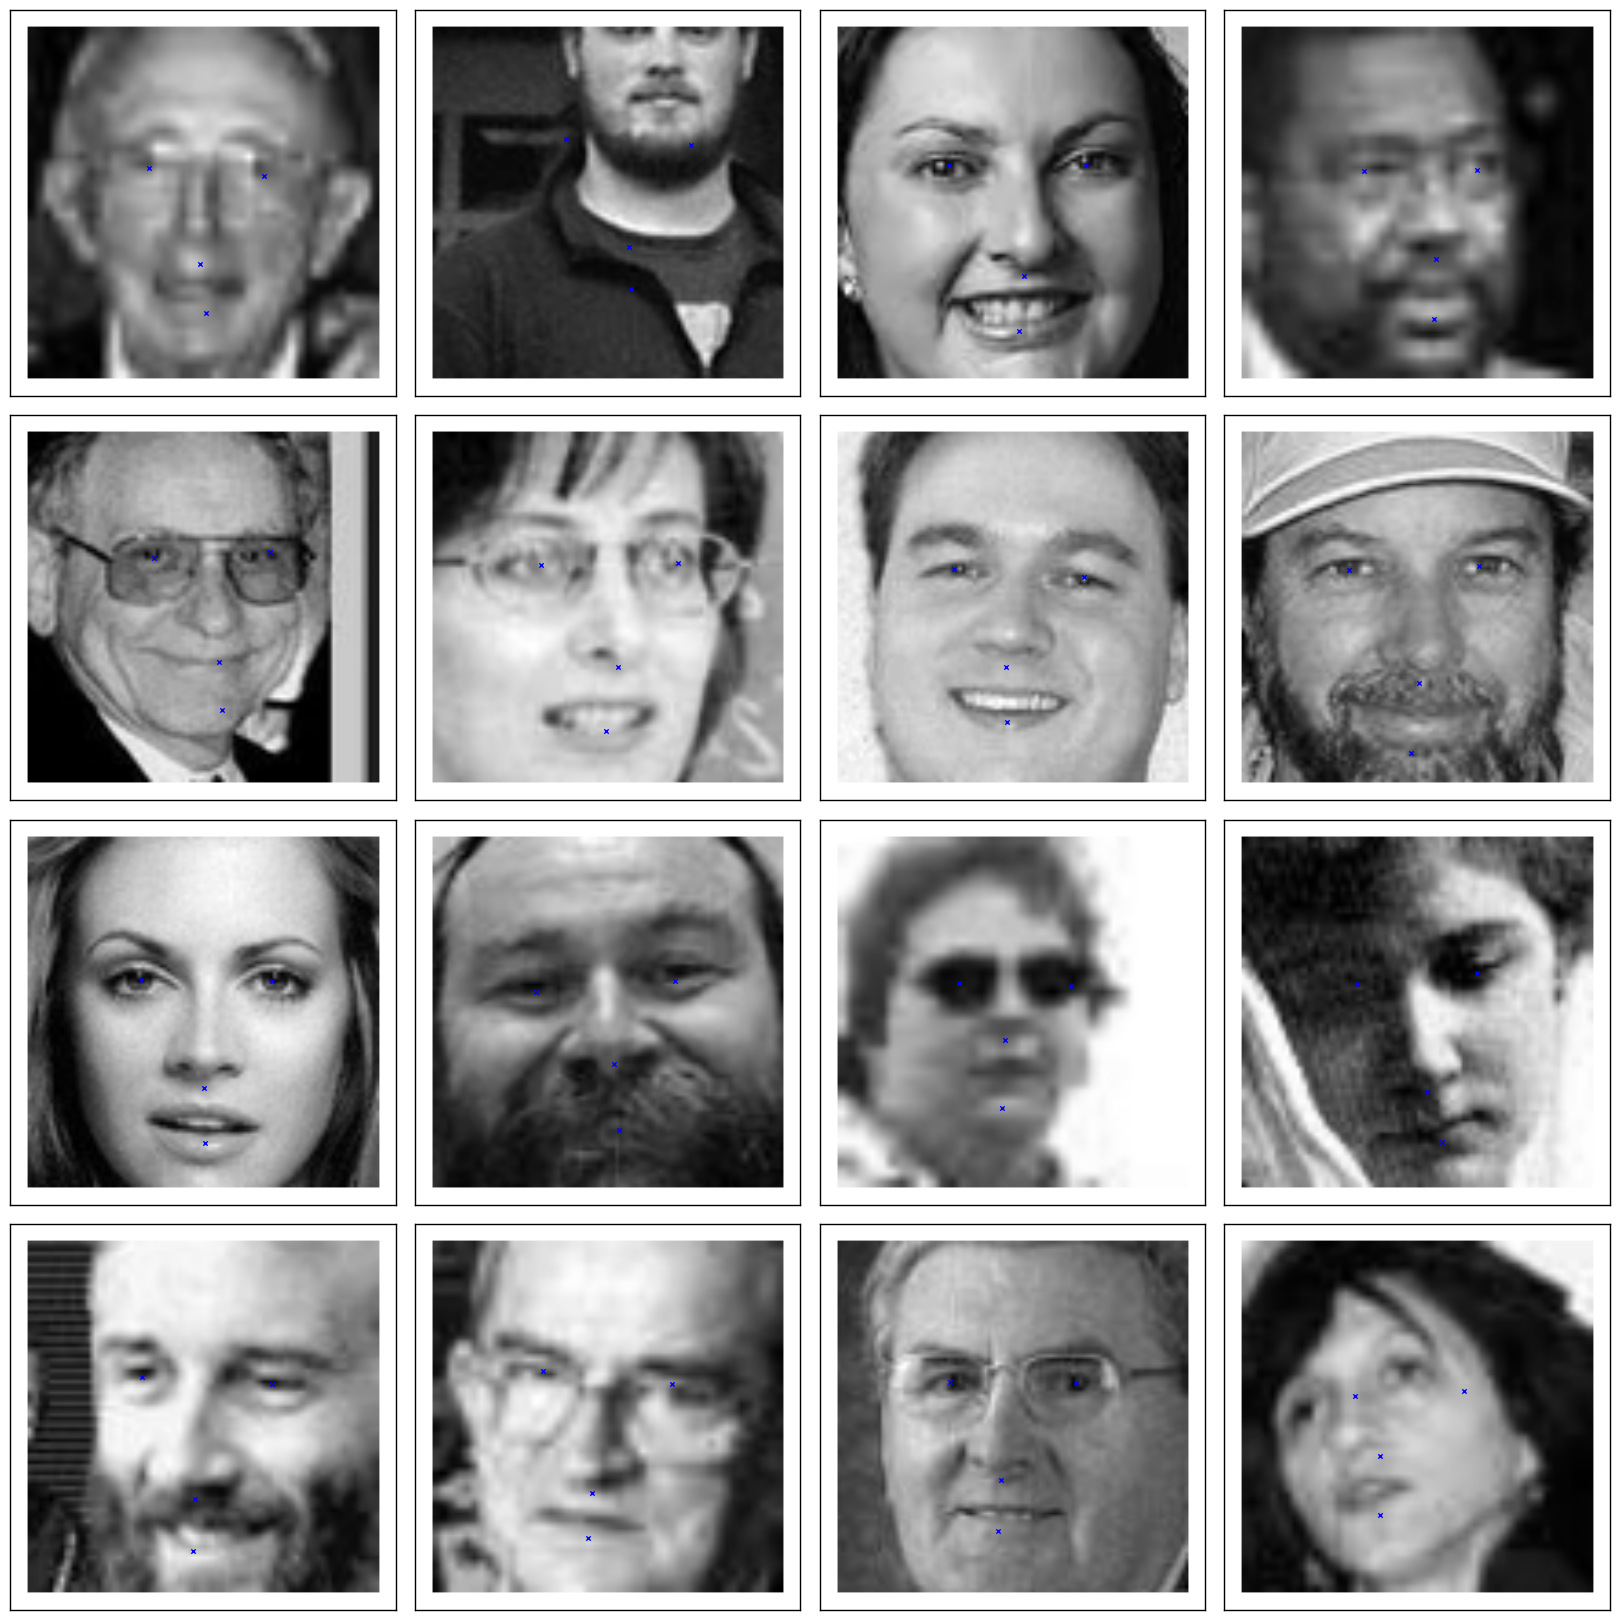

In [40]:
from random import randint

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(res_8))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_8[test_idx], res_8[test_idx], ax)
    
plt.show()

In [42]:
res_30_fmt = res_30 * 48 + 48
res_8_fmt = res_8 * 48 + 48

# Generating submissions
arr = [['RowId','ImageId','FeatureName','Location']]
rowIdx = 0

# Parsing first dataset
for i in range(0, res_30.shape[0]):
    for j in range(0, 30):
        rowIdx += 1
        arr.append([rowIdx, i + 1, keypoints[j], res_30_fmt[i,j]])
        
# Parsing second dataset
for i in range(0, res_8.shape[0]):
    for idx, j in enumerate(keypoints_ds_8):
        rowIdx += 1
        # Note ImageId starts from 592 for ds 2
        arr.append([rowIdx, 591 + i + 1, keypoints[j], res_8_fmt[i,idx]])

In [43]:
arr_df = pd.DataFrame(arr[1:], columns=arr[0])
submission = pd.merge(left = submissionImages, right=arr_df, how="left", \
                      left_on=["ImageId","FeatureName"], right_on=["ImageId","FeatureName"]) 

In [44]:
submissionSub = submission[[0,5]]
submissionSub.columns = ['RowId', 'Location']
submissionSub.to_csv('keypoint_submission_speciality.csv', index=False)

In [45]:
submissionSub

,RowId,Location
0,1,66.236694
1,2,36.092640
2,3,29.659542
3,4,35.677933
4,5,60.322250
5,6,37.372730
6,7,73.232170
7,8,38.059280
8,9,35.573982
9,10,37.145847


In [ ]:
graph_results(spec_30.items()[4][1])

In [ ]:
graph_results(spec_30.items()[5][1])

In [ ]:
graph_results(spec_30.items()[0][1])

In [ ]:
graph_results(spec_30.items()[1][1])

In [ ]:
graph_results(spec_30.items()[2][1])

In [ ]:
graph_results(spec_30.items()[3][1])

In [ ]:
graph_results(spec_8.items()[0][1])

In [ ]:
graph_results(spec_8.items()[1][1])

In [ ]:
graph_results(spec_8.items()[2][1])